# *pyfabric example 03: trabecular bone fabric tensor; multi-resolution*
Fabric tensor of trabecular bone of the proximal femur - comparison of scans with different spatial resolution

Created on:  25.10.2021 <br />
Last update: 09.04.2024 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2024
- Data source: QCT and HR-pQCT datasets were collected within the ANR-DFG TaCoSound project.
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
1. Load and inspect QCT and HR-pQCT datasets of the proximal femur using simpleITK
2. detect alignment cement markers on both images
3. compute transformation matrices for QCT to HR-pQCT image registration
4. apply 3D affine registration transformation to register QCT data to HR-pQCT
5. load mask of whole bone and of trabecular bone
6. compute trabecular core mesh; find centroids of anisotropy analysis
7. crop cube portions of trabecular bone and save as separate .MHA or stack of TIFFs

---
## Configuration and imports

In [1]:
import os
import sys
sys.path.append('/home/gianthk/PycharmProjects/pyfabric')
sys.path.append('/home/gianthk/PycharmProjects/BEATS/recon_utils')

# work_folder = '/media/gianthk/My Passport'
work_folder = '/home/gianthk'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import heapq
import pandas as pd
import SimpleITK as sitk
from imaging_utils import periosteummask
from myshow import myshow, myshow3d
from recon_utils import plot_midplanes, plot_projections
import pyfabric

In [3]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [4]:
%%html
<style>
table {float:left}
</style>

## Functions definition

In [5]:
def dist_table(coors):
    n_points = coors.shape[0]
    disttab = np.zeros([n_points, n_points])
    for i in range(n_points):
        for j in range(n_points):
            disttab[i,j] = np.linalg.norm(coors[i,:]-coors[j,:])
    return disttab

In [6]:
def markers_coors(BWimage):
    # get coordinates of 5 cement markers from binary image
    
    label_img = label(BWimage)
    
    props = regionprops_table(label_img, properties=('centroid','area'))
    
    props_df = pd.DataFrame(props)
    
    props_df.sort_values('area', ascending=False, inplace=True)
    props_df.reset_index(drop=True, inplace=True)
    
    markers_df = props_df[1:6]
    centroids = markers_df[['centroid-0', 'centroid-1', 'centroid-2']].to_numpy()
    
    distances = dist_table(centroids)
    
    for row in distances:
        row.sort()
        
    sum2dist = np.sum(distances[:,0:3], axis=1).tolist()
    min_3_dists = heapq.nsmallest(3,sum2dist)
    
    count = 0
    marker_id = np.zeros(3)
    for dist in min_3_dists:
        marker_id[count] = sum2dist.index(dist)
        count = count + 1

    M5_id = int(marker_id[0])
    M1_id = int(marker_id[1])
    M2_id = int(marker_id[2])
    
    
    sum3dist = np.sum(distances[:,0:4], axis=1).tolist()
    max_2_dists = heapq.nlargest(2,sum3dist)

    count = 0
    marker_id = np.zeros(2)
    for dist in max_2_dists:
        marker_id[count] = sum3dist.index(dist)
        count = count + 1

    M3_id = int(marker_id[0])
    M4_id = int(marker_id[1])
    
    marker_coors = np.zeros([5,3])
    marker_coors[0,:] = centroids[M1_id,:]
    marker_coors[1,:] = centroids[M2_id,:]
    marker_coors[2,:] = centroids[M3_id,:]
    marker_coors[3,:] = centroids[M4_id,:]
    marker_coors[4,:] = centroids[M5_id,:]
    
    return marker_coors

In [7]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    # Source: https://gist.github.com/mrajchl/ccbd5ed12eb68e0c1afc5da116af614a
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [8]:
def vectors2rotation3Dmatrix(a,b):
    # VECTORS2ROTATION3DMATRIX rotation matrix R that rotates vector a onto vector b
    #    R = vectors2rotation3Dmatrix(a, b)
    #    Returns 3x3 rotation matrix that transforms vector a into vector b.

    #  Example: rotate (clockwise) vector of 90deg around Z-axis.
    #    R = vectors2rotation3Dmatrix([0 1 0], [1 0 0]);
    #    R*[1; 0; 4]
    #    ans =
    #            0
    #            -1
    #            4

    #    See: http://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    #    ______________________________________________________

    #    Author:         Gianluca Iori (gianthk.iori@gmail.com)
    #    BSRT - Charite Berlin
    #    Created on:   01/01/2016
    #    Last update:  19/04/2016

    #    See also CROSS, DOT, NORM, EYE.

    #    this class is part of the synchro toolbox
    #    ______________________________________________________

    a = a/np.linalg.norm(a);
    b = b/np.linalg.norm(b);

    v = np.cross(a,b);
    s = np.linalg.norm(v);
    c = np.dot(a,b);
    skewv = [[0, -v[2], v[1]],
             [v[2], 0, -v[0]],
             [-v[1], v[0], 0]]

    R = np.eye(3) + skewv + np.matmul(skewv, skewv)*((1 - c)/(s**2));
#     return skewv
    return R

In [9]:
def align_with_XYplane(n12, n14):
    # return affine rotation matrix aligning the plane defined by vectors n12 and n14 with the X-Y plane
    angle_n12_n14 = np.arctan2(np.linalg.norm(np.cross(n12,n14)),np.dot(n12,n14))
    print('Angle between n12 and n14:', abs(angle_n12_n14/np.pi*180), 'deg')
    
    # Allign n12 with -X versor and n14 with +Y versor
    R_n12_x = vectors2rotation3Dmatrix(n12, [-1, 0, 0])
    n12_1 = np.matmul(R_n12_x, n12)
    n14_1 = np.matmul(R_n12_x, n14)
    
    R_n14_1_y = vectors2rotation3Dmatrix(n14_1, [0, 1, 0])
    n12_2 = np.matmul(R_n14_1_y, n12_1)
    n14_2 = np.matmul(R_n14_1_y, n14_1)
    
    return np.matmul(R_n14_1_y, R_n12_x)

In [10]:
def align_with_vectors(n12, n14, v12, v14):
    # return affine rotation matrix aligning the plane defined by vectors n12 and n14 with the plane defined by vectors v12 and v14 
    angle_n12_n14 = np.arctan2(np.linalg.norm(np.cross(n12,n14)),np.dot(n12,n14))
    print('Angle between n12 and n14:', abs(angle_n12_n14/np.pi*180), 'deg')
    
    angle_v12_v14 = np.arctan2(np.linalg.norm(np.cross(v12,v14)),np.dot(v12,v14))
    print('Angle between v12 and v14:', abs(angle_v12_v14/np.pi*180), 'deg')
    
    # Allign n12 with v12 versor and n14 with v14 versor
    R_n12_v12 = vectors2rotation3Dmatrix(n12, v12)
    n12_1 = np.matmul(R_n12_v12, n12)
    n14_1 = np.matmul(R_n12_v12, n14)
    
    R_n14_1_v14 = vectors2rotation3Dmatrix(n14_1, v14)
    n12_2 = np.matmul(R_n14_1_v14, n12_1)
    n14_2 = np.matmul(R_n14_1_v14, n14_1)
    
    return np.matmul(R_n14_1_v14, R_n12_v12)

In [11]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

In [12]:
def affine_trans(image, transform, tmatrix, verbose=False):
    new_transform = sitk.AffineTransform(transform)
    dimension = image.GetDimension()
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix = tmatrix
    if verbose:
        print(matrix)
    new_transform.SetMatrix(matrix.ravel())
    new_transform.SetInverse()
    new_transform.SetCenter(np.array(image.GetSize())/2 * image.GetSpacing())
    resampled = resample(image, new_transform)
    
    return resampled

In [13]:
def affine_trans2(image, tmatrix, verbose=False):
    # the transformation is applied around the center of the image not around its origin

    transform = sitk.AffineTransform(image.GetDimension())
    if verbose:
        print(tmatrix)
    transform.SetMatrix(tmatrix.ravel())
    transform.SetInverse()
    transform.SetCenter(np.array(image.GetSize())/2 * image.GetSpacing() + image.GetOrigin())
    resampled = resample(image, transform)
    
    return resampled

In [19]:
def plot_midplanes_sitk(img):
    plot_midplanes(sitk.GetArrayFromImage(img))

def plot_projections_sitk(img):
    plot_projections(sitk.GetArrayFromImage(img))

## Computational workflow - QCT
### Read and inspect input data

In [201]:
# input_file_HR = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/C0001524.mhd'
input_dir_QCT_DCM = '/home/gianthk/Data/TacoSound/QCTFEMUR_1955L_new/QCTFEMUR_1955L/Q_CT_DIAGBILANZ_HR_0003'
output_QCT = '/home/gianthk/Data/TacoSound/tmp/QCTFEMUR_1955L.mhd'
output_trab_mask = '/home/gianthk/Data/TacoSound/tmp/QCTFEMUR_1955L_trab.mha'
# input_file_QCT = work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/slices/slice_0000.tif'
specimen = '1955_L'
master_filename = '/home/gianthk/Data/TacoSound/tacosound_master_all.csv'

In [191]:
# read QCT dataset
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(input_dir_QCT_DCM)
reader.SetFileNames(dicom_names)

data_3D_QCT = reader.Execute()

ImageSeriesReader (0xf8db460): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.594295



Write as single MHD file

In [203]:
writer = sitk.ImageFileWriter()
writer.SetFileName(output_QCT)
writer.Execute(data_3D_QCT)

In [17]:
size_QCT = data_3D_QCT.GetSize()
print("Image size:", size_QCT[0], size_QCT[1], size_QCT[2])
vs_QCT = data_3D_QCT.GetSpacing() # it's a tuple
print("Image spacing:", vs_QCT[0], vs_QCT[1], vs_QCT[2])
dimension = data_3D_QCT.GetDimension()
print("Dimension: ", dimension)

Image size: 512 512 632
Image spacing: 0.29296875 0.29296875 0.30570522979397796
Dimension:  3


Inspect dataset

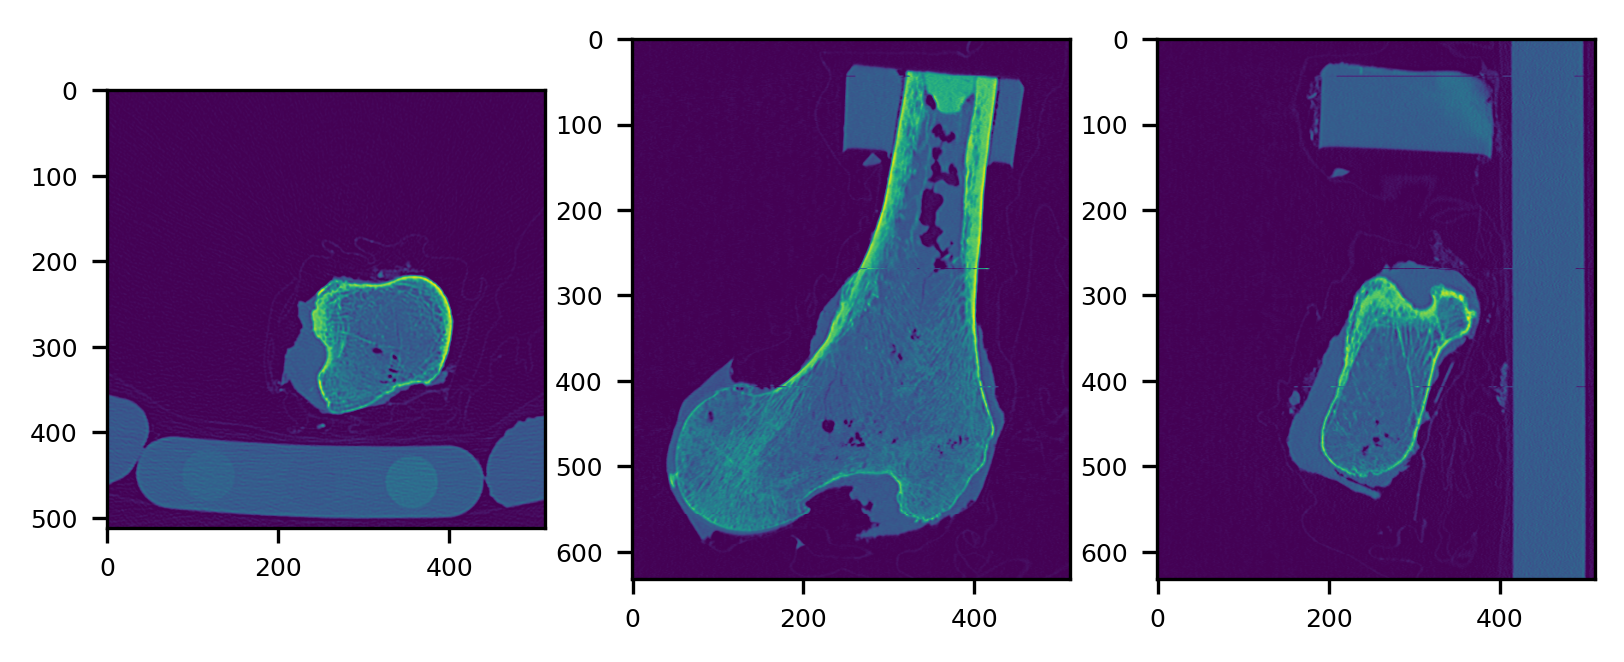

In [24]:
plot_midplanes_sitk(data_3D_QCT)

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

### Median filter

In [25]:
filter = sitk.MedianImageFilter()
filter.SetRadius(1)
data_3D_QCT = filter.Execute(data_3D_QCT)

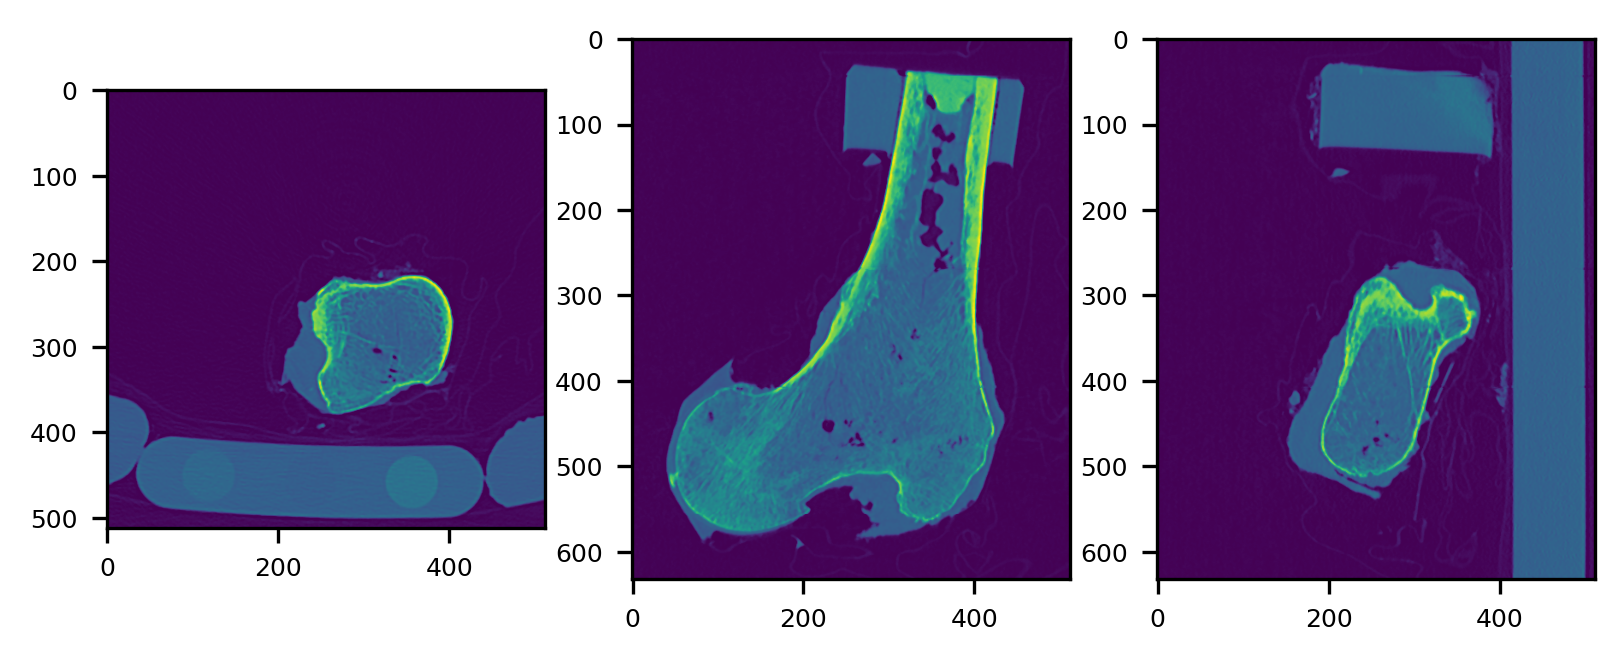

In [26]:
plot_midplanes_sitk(data_3D_QCT)

### Resample dataset
- isotropic voxel size
- for faster tests on resampled image

In [32]:
# vs_QCT_new = np.array(vs_QCT)*2 # downsample with factor 2 (non isotropic!)
vs_QCT_new = [0.5, 0.5, 0.5]
# vs_QCT_new = [1., 1., 1.]
data_3D_QCT = resample_img(data_3D_QCT, out_spacing=)

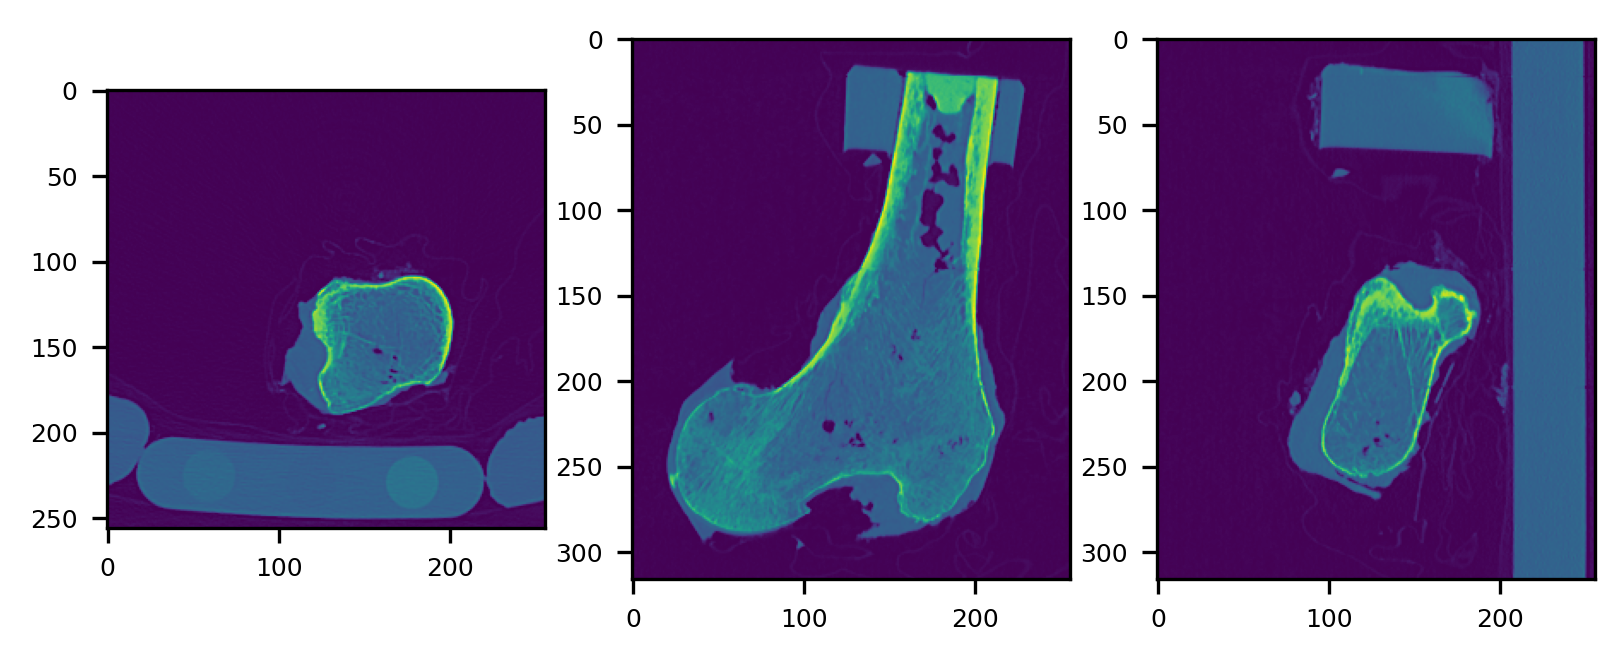

In [33]:
plot_midplanes_sitk(data_3D_QCT)

### Find cement markers
#### Segment markers and bone with multi otsu threshold
Multi-Otsu threshold of QCT dataset: 3 materials (backgroud, water, bone)

In [34]:
ts = threshold_multiotsu(sitk.GetArrayFromImage(data_3D_QCT))
print(ts)

[-463  686]


We add an image opening step to remove spurious voxels

In [35]:
data_3D_QCT_BW = morphology.binary_opening(sitk.GetArrayFromImage(data_3D_QCT) > ts[1])

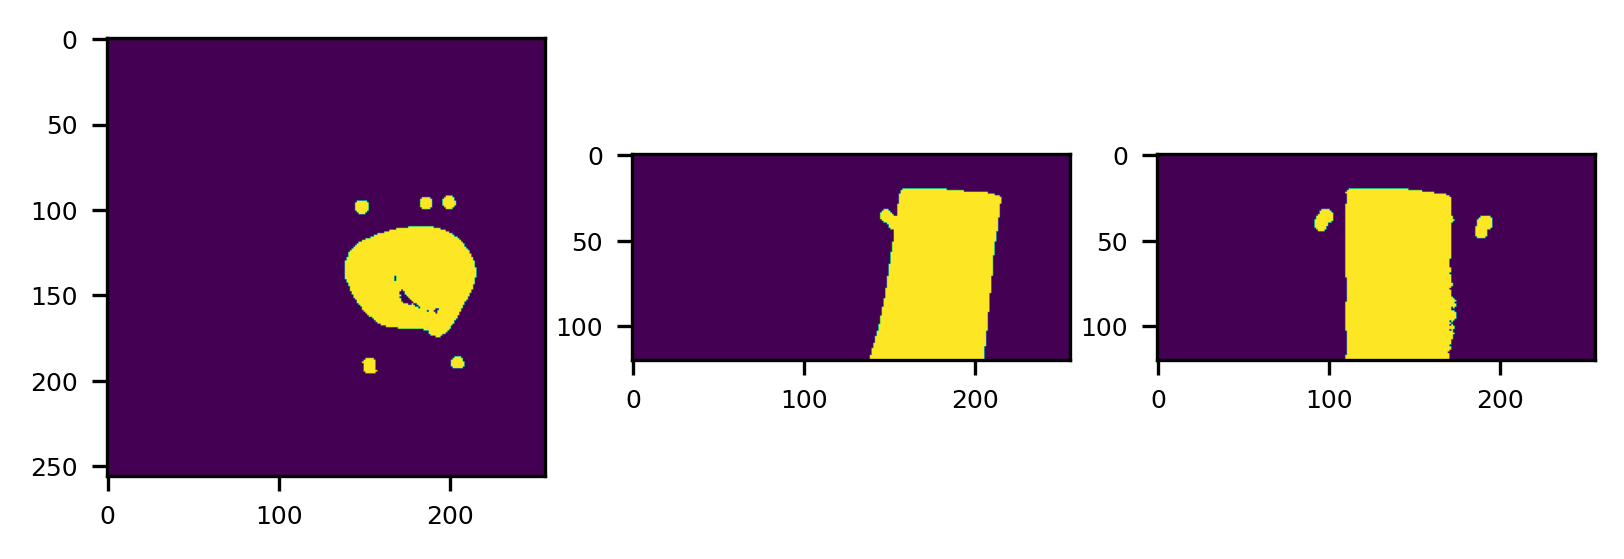

In [36]:
plot_projections(data_3D_QCT_BW[0:120,:,:])
plt.show()

#### Calculate markers coordinates
- QCT dataset:

In [37]:
markers_coordinates = markers_coors(data_3D_QCT_BW[0:120,:,:]) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates = np.fliplr(markers_coordinates*data_3D_QCT.GetSpacing()) # [x, y, z]
print(markers_coordinates)

[[121.88822451  55.85059691  23.72278792]
 [ 90.77126182  57.55522629  20.96241918]
 [ 93.56646771 111.99988996  23.2443882 ]
 [124.9759756  110.86774554  26.08963816]
 [113.71161898  56.09837582  22.4686472 ]]


###  Alignment and registration rotation matrices
Read marker coordinates from master file

In [25]:
master = pd.read_csv(master_filename, sep=',') # names=column_names, dtype=float

In [31]:
master['$specimen'][0]

'1955_L_S'

In [45]:
markers_coordinates_HR = np.array([[master['$M1x'][0], master['$M1y'][0], master['$M1z'][0]],
                          [master['$M2x'][0], master['$M2y'][0], master['$M2z'][0]],
                          [master['$M3x'][0], master['$M3y'][0], master['$M3z'][0]],
                          [master['$M4x'][0], master['$M4y'][0], master['$M4z'][0]],
                          [master['$M5x'][0], master['$M5y'][0], master['$M5z'][0]]])

In [46]:
print(markers_coordinates_HR)

[[101.714  92.103  14.022]
 [ 95.215  62.903  16.21 ]
 [ 41.419  74.894  16.994]
 [ 47.57  104.14   14.859]
 [100.051  84.267  14.167]]


Get n12, n14, v12, and v14 vectors

In [47]:
n12 = markers_coordinates[1,:] - markers_coordinates[0,:]
n14 = markers_coordinates[3,:] - markers_coordinates[0,:]

v12 = markers_coordinates_HR[1,:] - markers_coordinates_HR[0,:]
v14 = markers_coordinates_HR[3,:] - markers_coordinates_HR[0,:]

#### Rotation matrix to allign QCT markers with X-Y plane

In [57]:
# R_xy = align_with_XYplane(n12, n14)
# print(R_xy)

#### Rotation matrix to allign QCT markers with HR-pQCT markers

In [56]:
R_HR = align_with_vectors(n12, n14, v12, v14)
print(R_HR)

Angle between n12 and n14: 90.16075369051657 deg
Angle between v12 and v14: 89.92311184533372 deg
[[ 0.15818876 -0.98738324  0.00711769]
 [ 0.97415485  0.15723845  0.16216779]
 [-0.16124093 -0.01871939  0.98673753]]


Store transformation matrix

In [82]:
# np.save(work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/R_HR_res10.npy', R_HR)

additional 180deg rotation fot STANCE LEFT samples

In [104]:
# R_z180 = np.array([[-1.0, 0.0, 0.0],
#                    [0.0, -1.0, 0.0],
#                    [0.0, 0.0, 1.0]])

In [85]:
# # one test 15 deg rotation matrix around Z-axis
# theta = 15 # [deg]
# theta = -np.pi * theta / 180
# R_1rot = np.array([[np.cos(theta), -np.sin(theta), 0.0],
#                    [np.sin(theta), np.cos(theta), 0.0],
#                    [0.0, 0.0, 1.0]])

In [114]:
# R_xy2 = np.matmul(R_z180, R_xy)

### Apply affine transformation to QCT stack

In [67]:
#### Transform dataset - align with X-Y plane
# img_trans = affine_trans(data_3D_QCT, transform=affine, tmatrix=R_xy)

#### Transform dataset - align with HR-pQCT dataset

In [114]:
data_3D_QCT_trans = affine_trans2(data_3D_QCT, tmatrix=R_HR) # R_1rot

In [110]:
data_3D_QCT_res_trans = affine_trans2(data_3D_QCT_res, tmatrix=R_HR) # R_HR

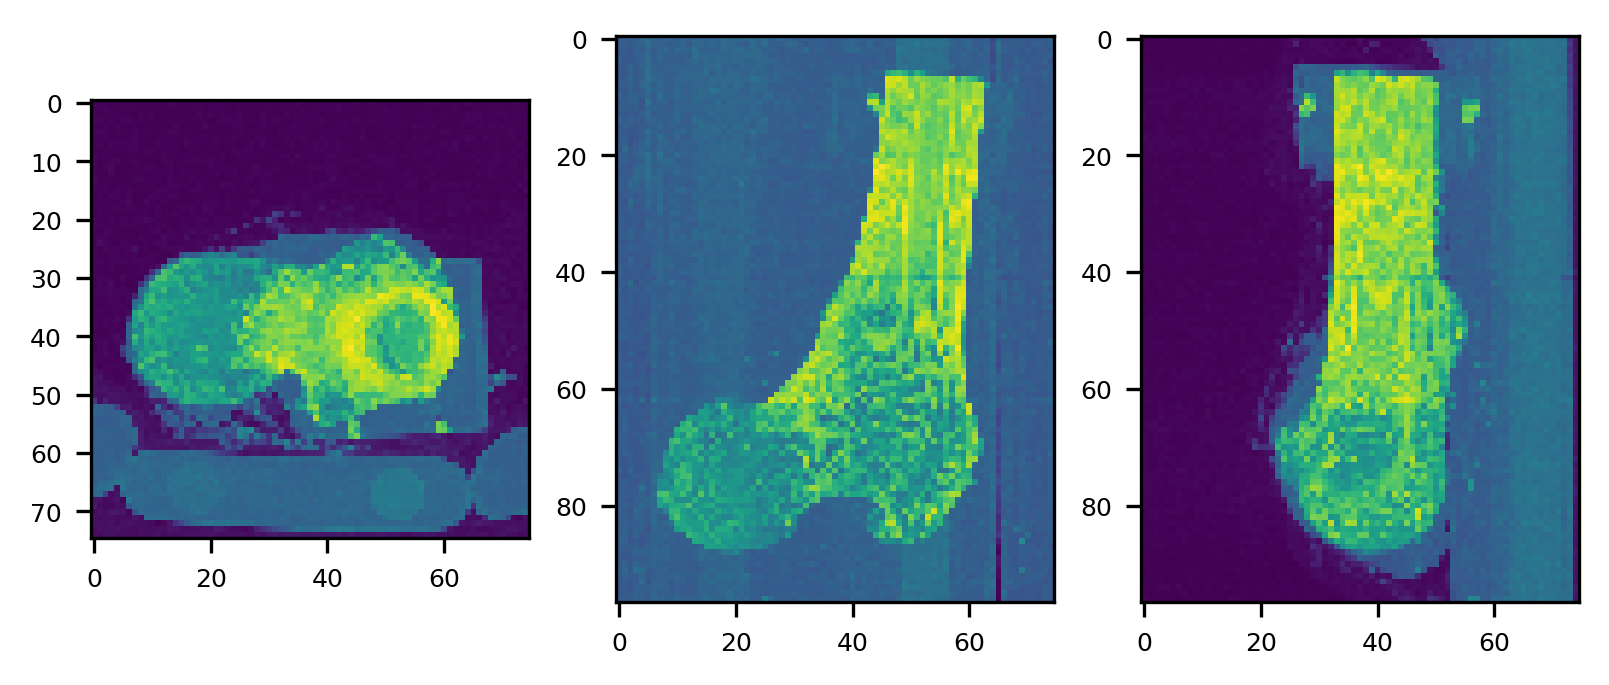

In [105]:
plot_projections(sitk.GetArrayFromImage(data_3D_QCT_res))

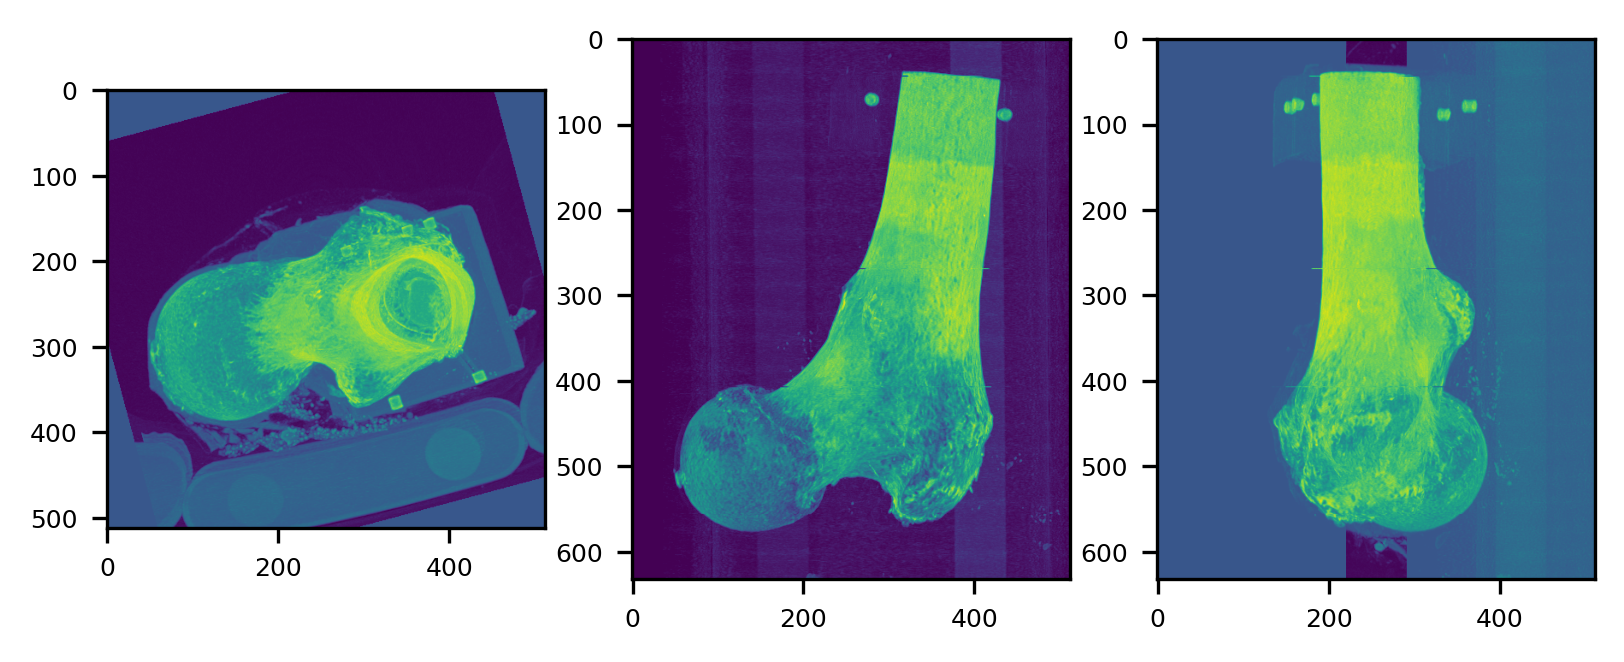

In [113]:
plot_projections(sitk.GetArrayFromImage(data_3D_QCT_trans))

## Bone compartments masks
### Whole bone mask (periosteum mask)

In [38]:
# data_3D_BW_peri = periosteummask(data_3D>(ts_HR[1]-1000), closepixels=10, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)
data_3D_QCT_BW_peri = periosteummask(sitk.GetArrayFromImage(data_3D_QCT)>(ts[1]-100), closepixels=10, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [00:05<00:00, 54.70it/s]


Assign to a new itk image

In [39]:
data_3D_QCT_BW_peri = sitk.GetImageFromArray(data_3D_QCT_BW_peri.astype('uint8'))
data_3D_QCT_BW_peri.CopyInformation(data_3D_QCT)

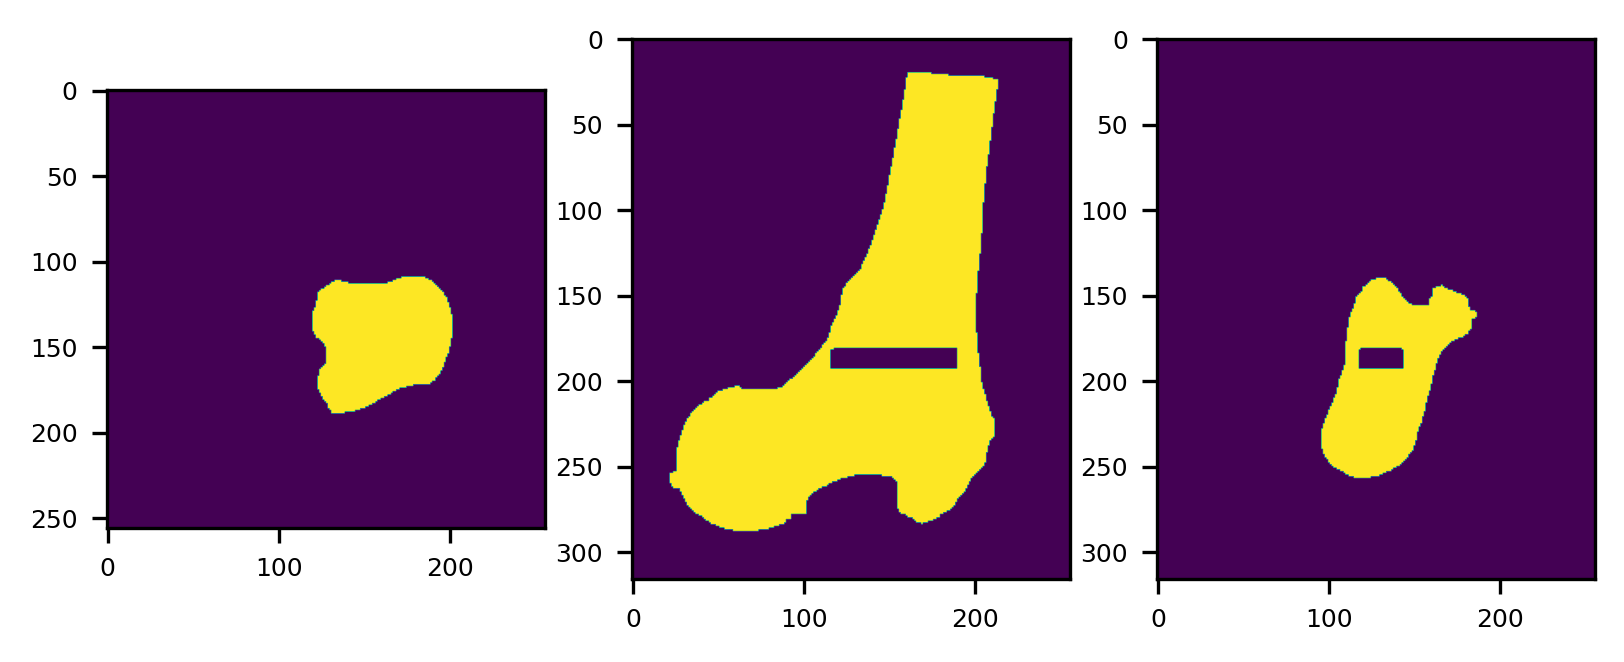

In [40]:
# plot_midplanes_itk(data_3D_QCT>(ts[1])-100)
plot_midplanes_itk(data_3D_QCT_BW_peri)

### Iterative Voting Hole Filling Filter
Performs the filling operation multiple times until no pixels change, or maximum number of iterations is reached.

In [41]:
hole_filling_filter = sitk.VotingBinaryIterativeHoleFillingImageFilter()
hole_filling_filter.SetRadius(3)
hole_filling_filter.SetMajorityThreshold(1)
hole_filling_filter.SetBackgroundValue(0)
hole_filling_filter.SetForegroundValue(1)
hole_filled_image = hole_filling_filter.Execute(data_3D_QCT_BW_peri)

### Image close

In [44]:
closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
closing_filter.SetKernelRadius(8)
closed_image = closing_filter.Execute(hole_filled_image)

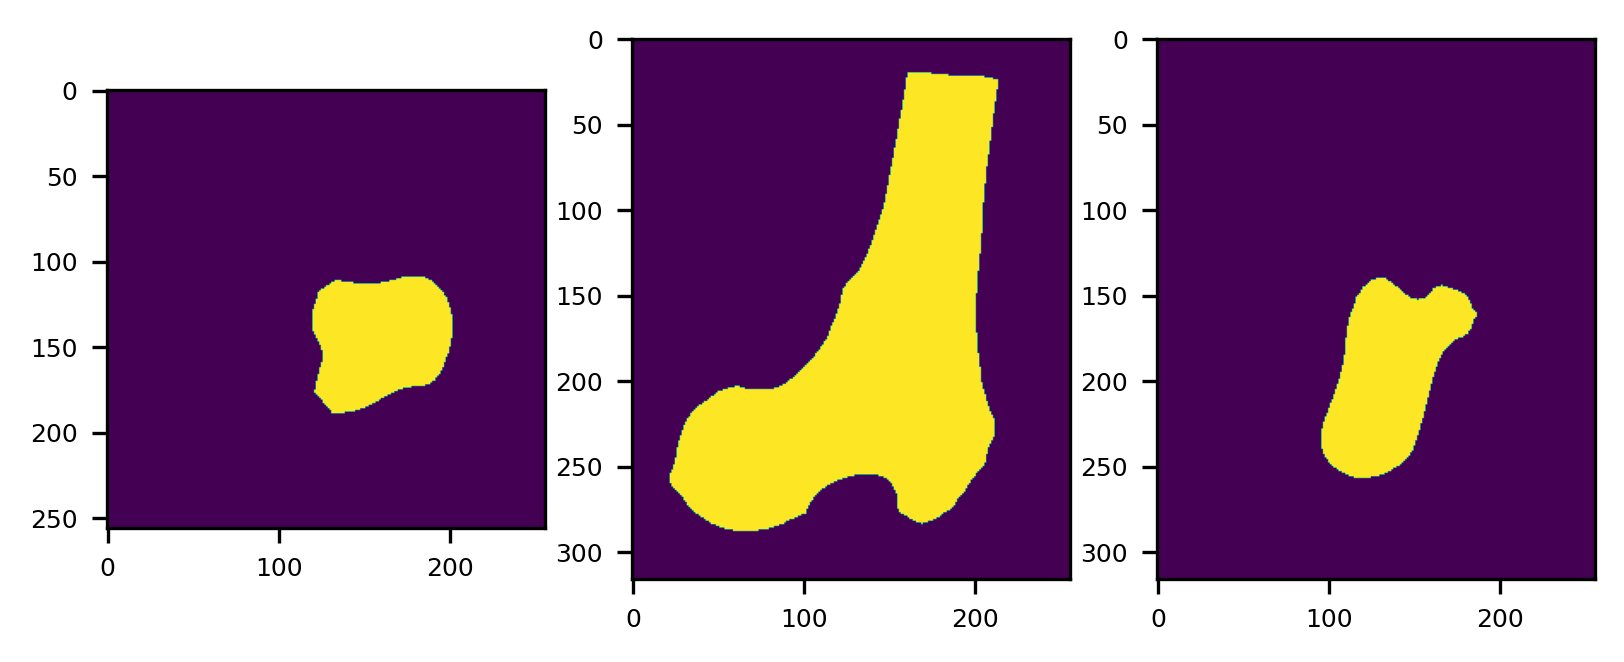

In [45]:
plot_midplanes_itk(closed_image)

Write whole bone mask

In [6]:
# perimask_file_HR = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/masks/periosteum/slice.tiff'

In [29]:
# dxchange.writer.write_tiff_stack(data_3D_BW_peri, perimask_file_HR, axis=0, digit=4, start=0, overwrite=True)

Reload whole bone mask

In [14]:
# data_3D_BW_peri = ru.read_tiff_stack(perimask_file_HR)
# vs = [0.303, 0.303, 0.303] # [Z, Y, X][mm]

### Trabecular bone mask
We erode the whole bone mask to obtain a tentative mesh of the trabecular core

In [87]:
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius(8)
data_3D_BW_trab = erode_filter.Execute(closed_image)

In [48]:
myshow(sitk.LabelOverlay(data_3D_QCT, data_3D_BW_trab))

interactive(children=(IntSlider(value=157, description='z', max=315), Output()), _dom_classes=('widget-interac…

Delete shaft portion from mask: this is done to remove thin struts and facilitate meshing

In [88]:
tmp = sitk.GetArrayFromImage(data_3D_BW_trab).astype('uint8')
tmp[0:100, :, :] = 0
data_3D_BW_trab = sitk.GetImageFromArray(tmp)
data_3D_BW_trab.CopyInformation(data_3D_QCT)

In [89]:
myshow(sitk.LabelOverlay(data_3D_QCT, data_3D_BW_trab))

interactive(children=(IntSlider(value=157, description='z', max=315), Output()), _dom_classes=('widget-interac…

#### Write trabecular core mask

In [92]:
writer = sitk.ImageFileWriter()
writer.SetFileName(output_trab_mask)
writer.Execute(data_3D_BW_trab)

## Mesh of trabecular core
Create tetrahedra mesh of trabecular core: volume meshing is done using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [93]:
import pygalmesh

In [35]:
# # min_facet_angle=20,  lloyd=True,
# size_f = 8 # size factor
# mesh_trab = pygalmesh.generate_from_array(np.transpose(data_3D_BW_trab, [2, 1, 0]).astype('uint8'),
#                                           tuple(vs),
#                                           max_facet_distance=size_f*min(vs),
#                                           max_cell_circumradius=3*size_f*min(vs)
#                                          )

In [208]:
# min_facet_angle=20,  lloyd=True,
size_f = 8 # size factor
mesh_trab = pygalmesh.generate_from_array(np.transpose(sitk.GetArrayFromImage(data_3D_BW_trab), [2, 1, 0]),
                                          data_3D_BW_trab.GetSpacing(),
                                          max_facet_distance=size_f*min(data_3D_BW_trab.GetSpacing()),
                                          max_cell_circumradius=3*size_f*min(data_3D_BW_trab.GetSpacing())
                                         )

construct initial points (nb_points: 12)
12/12 initial point(s) found...
Start surface scan...Scanning triangulation for bad facets (sequential) - number of finite facets = 52...
Number of bad facets: 12
scanning edges (lazy)
scanning vertices (lazy)
end scan. [Bad facets:12]

Refining Surface...
Legend of the following line: (#vertices,#steps,#facets to refine,#tets to refine)
(60,47,0,0) (9627.5 vertices/s))
Total refining surface time: 0.00490308s

Start volume scan...Scanning triangulation for bad cells (sequential)... 255 cells scanned, done.
Number of bad cells: 100
end scan. [Bad tets:100]

Refining...
Legend of the following line: (#vertices,#steps,#facets to refine,#tets to refine)
(87,38,0,0) (13649.4 vertices/s))
Total refining volume time: 0.00280404s
Total refining time: 0.00829411s

Running sliver perturbation...
Legend of the following line: (#vertices in pqueue, #iterations, #fails)
bound 12: (8,5,0) (599.6 iteration/s))
Total perturbation time: 0.00835514s
Perturbation

In [209]:
mesh_trab

<meshio mesh object>
  Number of points: 87
  Number of cells:
    triangle: 308
    tetra: 208
  Point data: medit:ref
  Cell data: medit:ref

Remove triangles

In [210]:
mesh_trab.remove_lower_dimensional_cells()

{'triangle'}

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [211]:
# filename_mesh_out = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/masks/trabecular_coarse.vtk'
filename_mesh_out = '/home/gianthk/Data/TacoSound/tmp/QCTFEMUR_1955L_trab_mesh_coarse.vtk'

In [212]:
mesh_trab.write(filename_mesh_out)

Reload the mesh (if you have already generated it and want to start the notebook from this point)

In [9]:
# import meshio
# mesh_trab = meshio.read(filename_mesh_out)

### Get Barycenter of each cell of the trabecular core (QCT data)

In [217]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1] # x, y, z

In [218]:
# filename_barycenters = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/masks/trabecular_coarse_barycenters.npy'
filename_barycenters = '/home/gianthk/Data/TacoSound/tmp/QCTFEMUR_1955L_trab_mesh_coarse_barycenters.npy'

Save array of cells barycenters coordinates

In [219]:
np.save(filename_barycenters, cells_bary)

Reload it

In [10]:
# cells_bary = np.load(filename_barycenters)

## Crop trabecular bone portions
--- testing ---

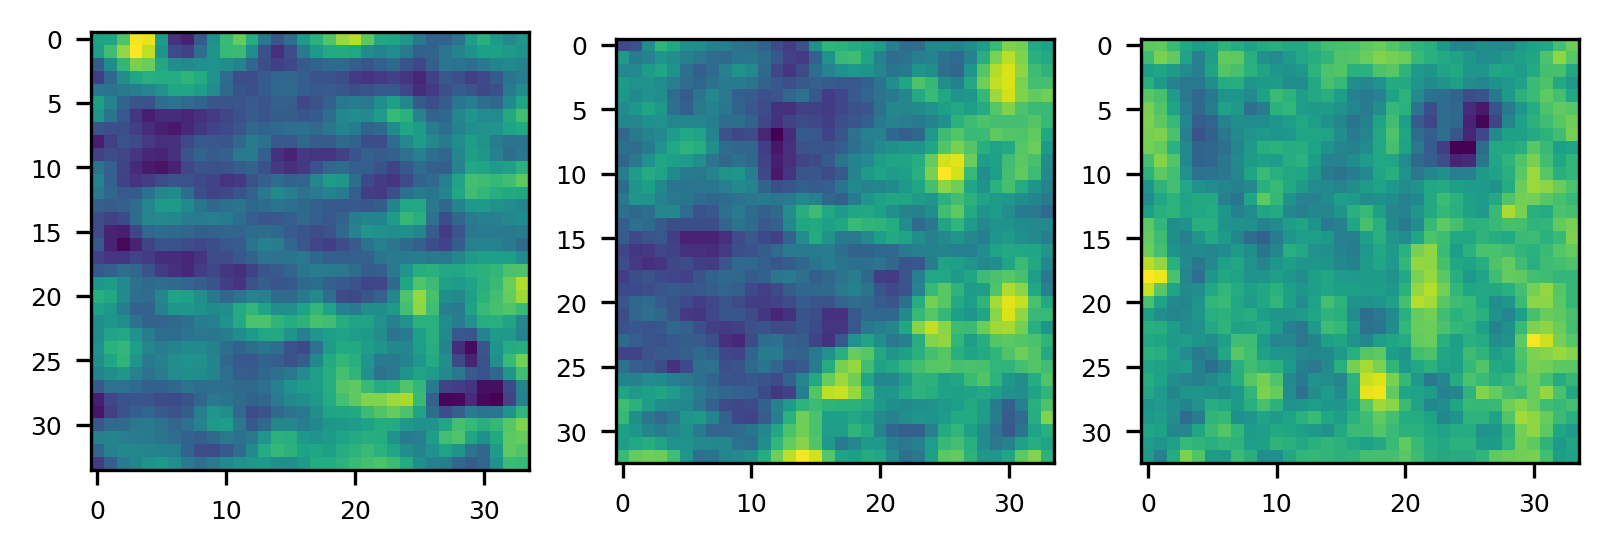

In [244]:
id = 203
size = np.array([5., 5., 5.]) # mm
size = np.array([10., 10., 10.]) # mm
# print(cells_bary[id])
# print(np.round((cells_bary[id] - size/2)/data_3D_BW_trab.GetSpacing()).astype('int'))
# print(np.round((cells_bary[id] + size/2)/data_3D_BW_trab.GetSpacing()).astype('int'))

crop_start = np.round((cells_bary[id] - size/2)/data_3D_QCT.GetSpacing()).astype('int')
crop_end = np.round((cells_bary[id] + size/2)/data_3D_QCT.GetSpacing()).astype('int')
# crop_size = crop_end - crop_start

test_crop = sitk.GetArrayFromImage(data_3D_QCT)[crop_start[2]:crop_end[2],crop_start[1]:crop_end[1],crop_start[0]:crop_end[0]]
# print(test_crop.shape)

plot_midplanes(test_crop)

In [207]:
cells_bary[42]/data_3D_QCT.GetSpacing()

array([398.67054688, 249.76      , 393.87334532])

In [86]:
data_3D = io.imread(input_file_HR, plugin='simpleitk')
vs = [0.303, 0.303, 0.303] # [Z, Y, X][mm]

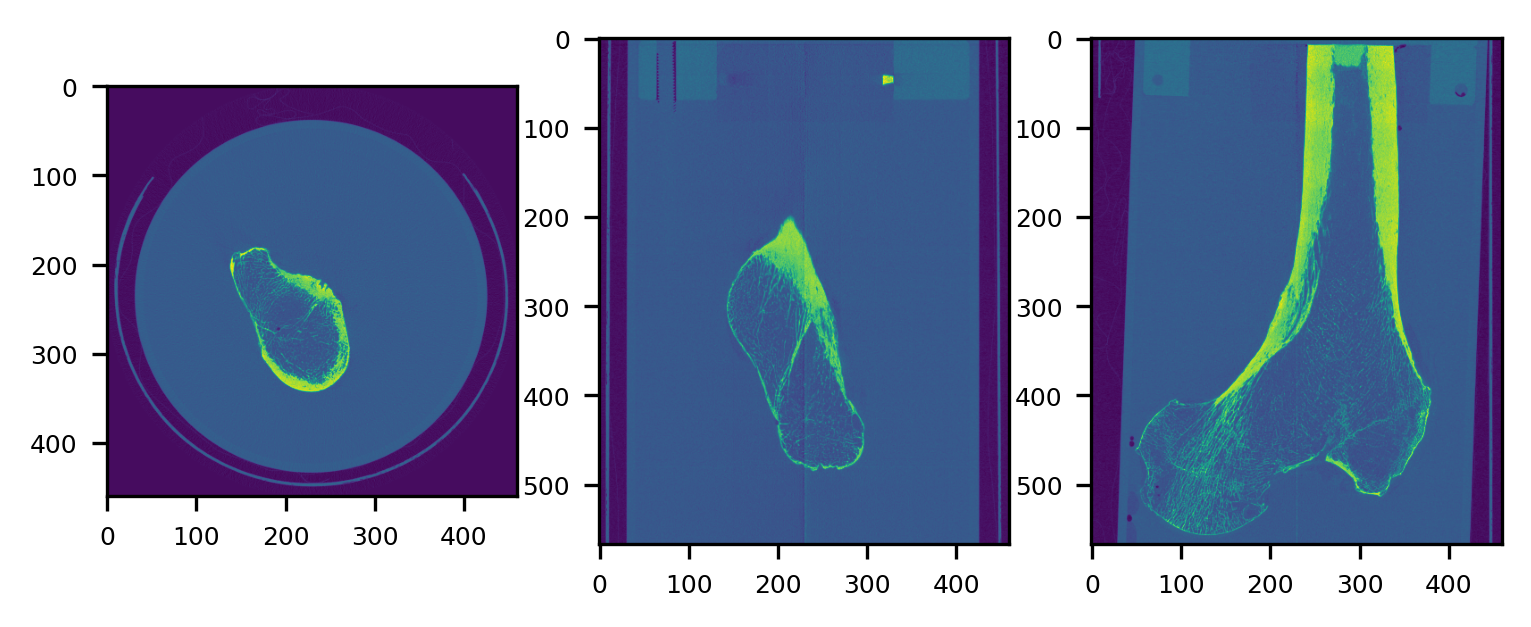

In [10]:
# Inspect dataset
ru.plot_midplanes(data_3D)
plt.show()

### Find cement markers
#### Segment markers and bone with multi otsu threshold
Multi-Otsu threshold of QCT dataset: 3 materials (backgroud, water, bone)

High resolution dataset:

In [13]:
ts_HR = threshold_multiotsu(data_3D)
print(ts_HR)

[1018 3860]


In [ ]:
data_3D_BW = morphology.binary_opening(data_3D[0:90, :, :] > ts_HR[1])

#### Calculate markers coordinates
- HR-pQCT dataset:

In [18]:
markers_coordinates_HR = markers_coors(data_3D_BW) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates_HR = np.fliplr(markers_coordinates_HR*vs) # [x, y, z]
print(markers_coordinates_HR)

[[ 95.14473492 101.32866983  14.13808076]
 [ 97.73270739  71.42278125  13.96138494]
 [ 41.60149698  66.58067775  13.84548791]
 [ 38.80502449  96.19050367  14.01047265]
 [ 95.92570823  93.45705717  13.65874421]]


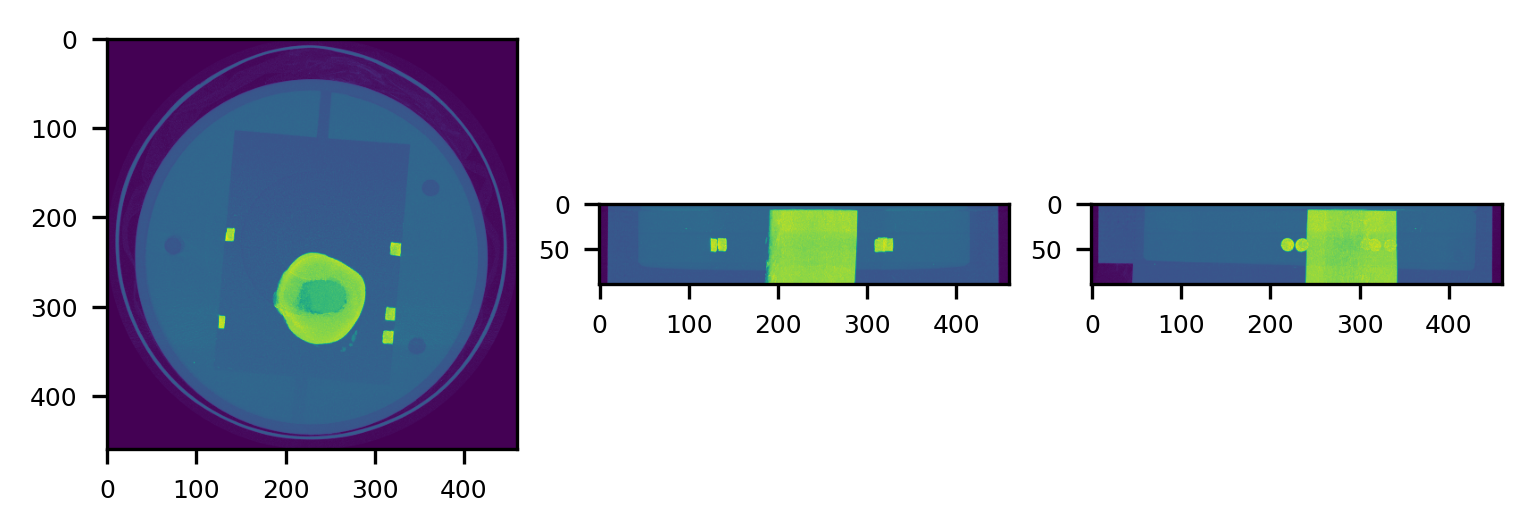

In [79]:
ru.plot_projections(data_3D[0:90,:,:])

Reload R_HR transformation matrix

In [83]:
# R_HR = np.load(work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/R_HR_res10.npy')

In [96]:
# import pygalmesh

### Get Barycenter of each cell (HR-pQCT data)

In [10]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1]

In [9]:
filename_barycenters = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/masks/trabecular_coarse_barycenters.npy'

Save array of cells barycenters coordinates

In [13]:
np.save(filename_barycenters, cells_bary)

Reload it

In [10]:
cells_bary = np.load(filename_barycenters)

### Get cells barycenters on QCT data

In [69]:
cells_bary_tr = np.transpose(np.matmul(R_HR, np.transpose(cells_bary)))

Use marker 5 coordinates to get offset between HR-pQCT and transformed QCT ref systems (rigid translatio)

In [70]:
M5_coors_QCT = np.array([105.82608471, 41.55939576, 27.14610941])

In [71]:
M5_coors = np.array([95.14473492, 101.32866983, 14.13808076])

In [72]:
M5_coors_tr = np.matmul(M5_coors, R_HR)

In [73]:
offset = M5_coors_QCT-M5_coors_tr

Transform barycenter coordinates into QCT ref system

In [78]:
cells_bary_tr = np.matmul(cells_bary, R_HR) + offset

## Fabric worm
Extract fabric tensor at cells barycenters
### HR-pQCT data
> Run this section on high-resolution data!

| ver | runtime |
|-----|---------|
| `to01(ROIACF)>ACF_threshold` | 04:38<00:00, 51.14it/s |
| `envelope(to01andbinary(ROIACF, ACF_threshold))` | 04:15<00:00, 55.66it/s |

In [116]:
# pyfabric ACF parameters for HR-pQCT (0.303 mm)
ROIsize = 20
ACF_threshold=0.33
ROIzoom=True
zoom_size=14
zoom_factor=2

In [117]:
evecs, radii, evals, fabric_comp, DA = pyfabric.fabric_pointset(data_3D,
                                                                cells_bary/vs,
                                                                ROIsize,
                                                                ACF_threshold,
                                                                ROIzoom,
                                                                zoom_size,
                                                                zoom_factor)

100%|██████████| 1717/1717 [00:15<00:00, 114.10it/s]


### QCT data

In [118]:
# pyfabric ACF parameters for QCT (0.303 mm)
ROIsize = 20
ACF_threshold=0.33
ROIzoom=True
zoom_size=14
zoom_factor=2

In [119]:
evecs_QCT, radii_QCT, evals_QCT, fabric_comp_QCT, DA_QCT = pyfabric.fabric_pointset(data_3D_QCT, 
                                                                                    cells_bary_tr/vs_QCT,
                                                                                    ROIsize,
                                                                                    ACF_threshold,
                                                                                    ROIzoom,
                                                                                    zoom_size,
                                                                                    zoom_factor)

100%|██████████| 1717/1717 [00:20<00:00, 84.01it/s]


### Comparison

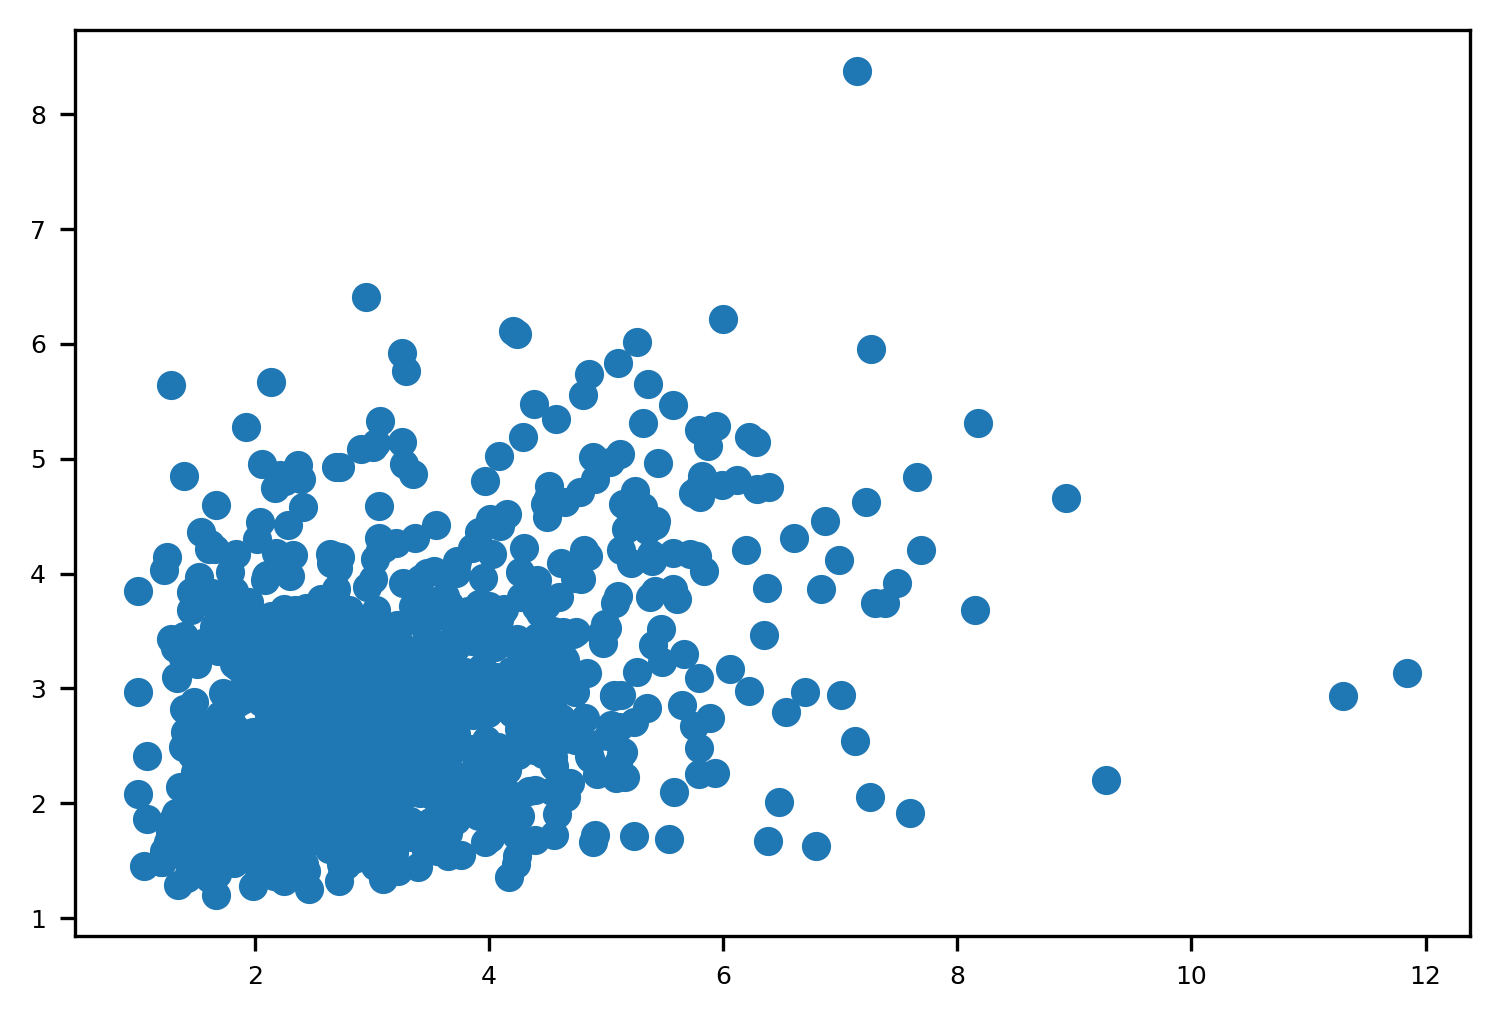

In [120]:
# plt.scatter(radii[:,2], radii_QCT[:,2], label='r3')
plt.scatter(DA, DA_QCT, label='DA')
plt.show()

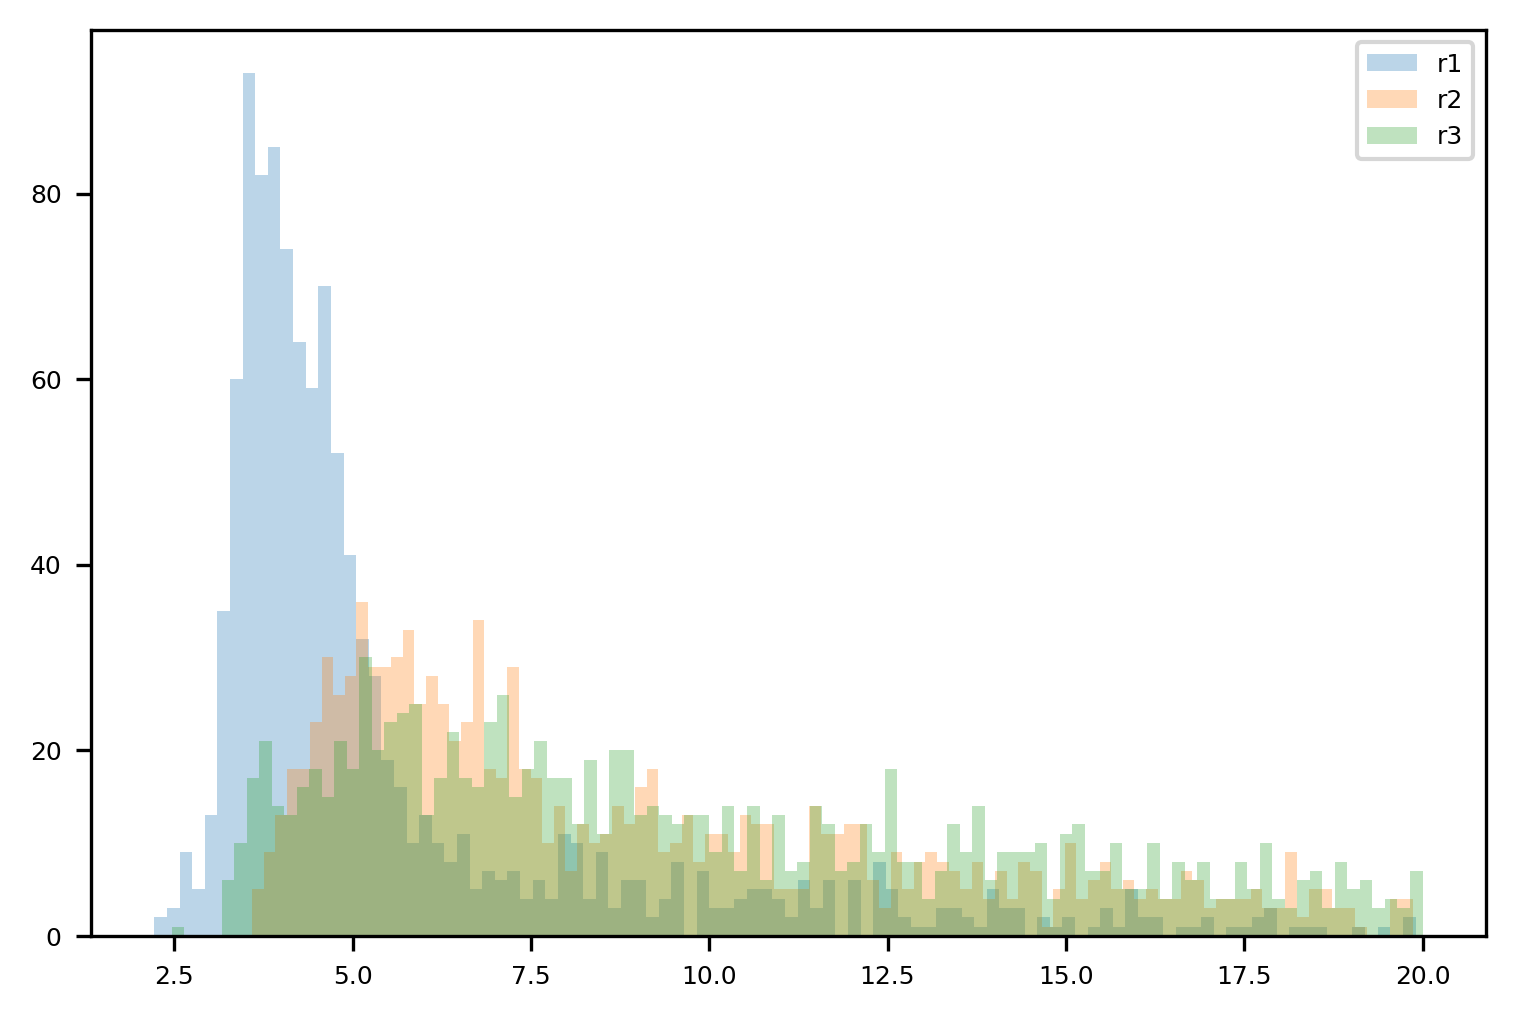

In [121]:
fig2, ax2 = plt.subplots()

plt.hist(radii_QCT[:,0].ravel(), alpha=0.3, bins=100, label='r1')
plt.hist(radii_QCT[:,1].ravel(), alpha=0.3, bins=100, label='r2')
plt.hist(radii_QCT[:,2].ravel(), alpha=0.3, bins=100, label='r3')
# plt.hist(radii.ravel(), alpha=0.4, bins=100)
plt.legend(loc='upper right')
plt.show()

In [ ]:
cell = 400

In [125]:
np.round((cells_bary[400,:]/vs)-ROIsize/2).astype('int')

array([210, 240, 435])

In [107]:
cells_bary_tr[400,:]/vs_QCT

array([250.84133768, 283.08992009, 487.80425491])

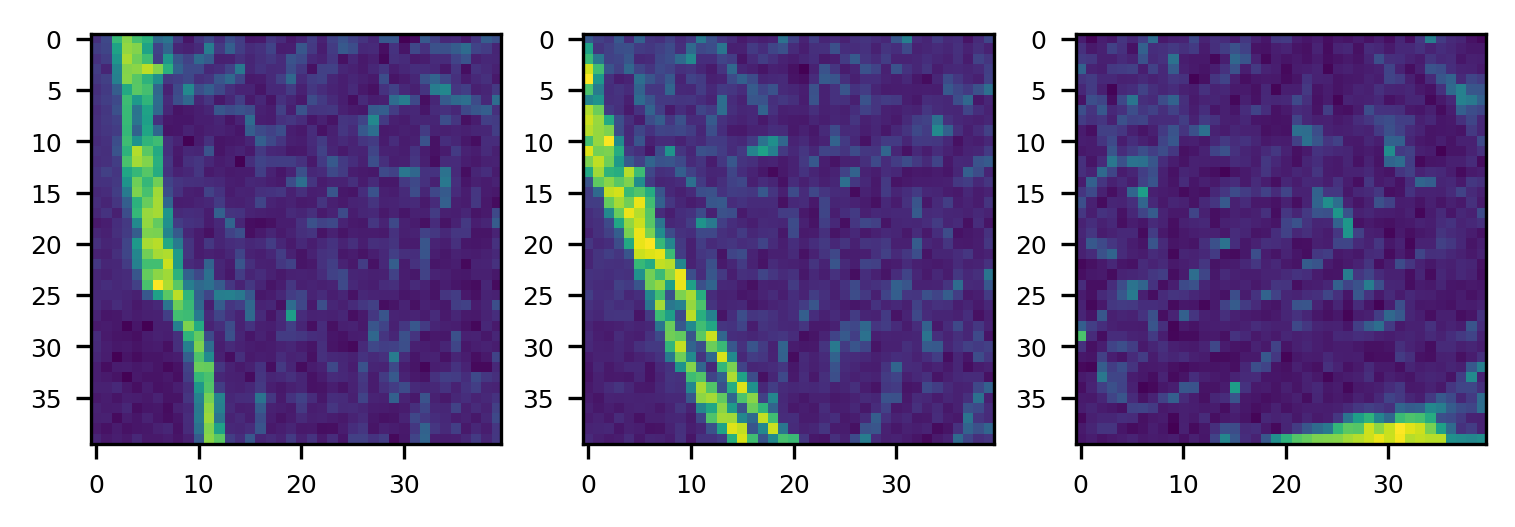

In [115]:
ru.plot_midplanes(data_3D[425:465, 229:269, 199:239])

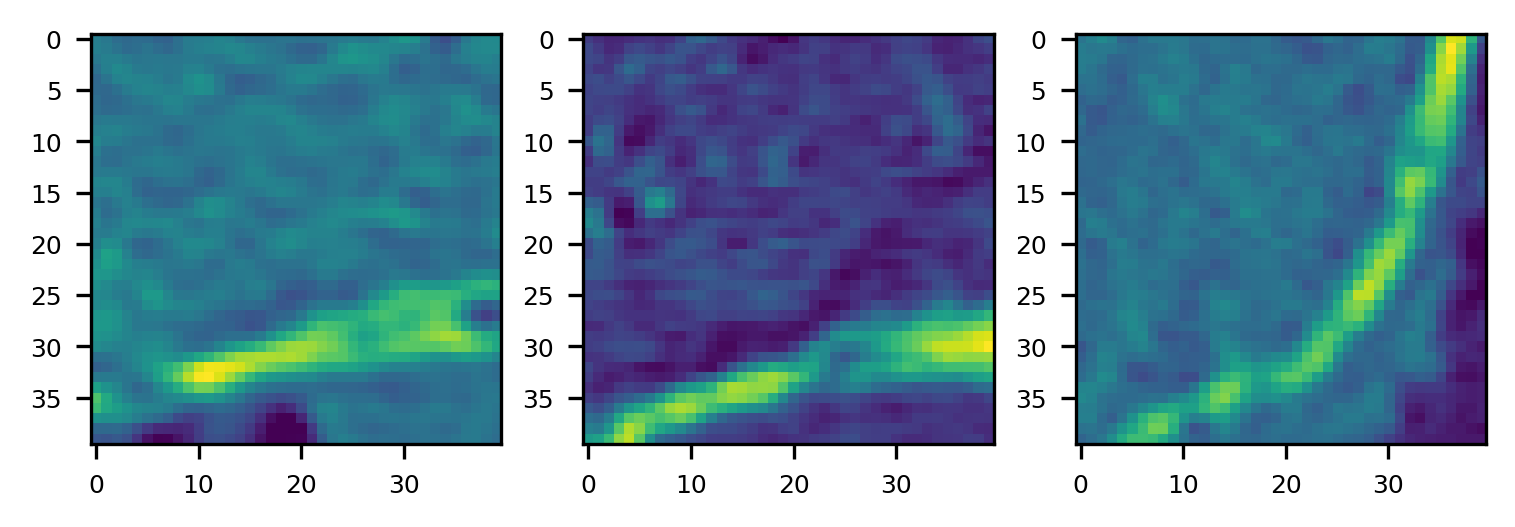

In [114]:
ru.plot_midplanes(data_3D_QCT[467:507, 263:303, 230:270])

---
# scratch:

In [16]:
np.matmul(cells_bary[0,:], R_HR)

array([ 67.54942104, -57.76803318,  95.46131422])

In [17]:
cells_bary[0,:]

array([69.918175, 68.84974 , 85.930756], dtype=float32)

Marker 3, 5 coordinates

In [46]:
M5_coors_QCT = np.array([105.82608471, 41.55939576, 27.14610941])

In [47]:
M5_coors = np.array([95.14473492, 101.32866983, 14.13808076])

In [48]:
M3_coors_QCT = np.array([99.37972134, 97.17195701, 20.42490844])

In [49]:
M3_coors = np.array([38.80502449, 96.19050367, 14.01047265])

Transform to HR-pQCT ref system and get offset (translation)

In [50]:
M5_coors_QCT_tr = np.matmul(R_HR, M5_coors_QCT)

In [51]:
offset = M5_coors-M5_coors_QCT_tr

In [52]:
offset

array([130.79289459,  -6.38544058, -13.97124196])

In [53]:
M5_coors

array([ 95.14473492, 101.32866983,  14.13808076])

In [54]:
M5_coors_QCT_tr+offset

array([ 95.14473492, 101.32866983,  14.13808076])

Check on M3 coordinates

In [55]:
M3_coors_QCT_tr = np.matmul(R_HR, M3_coors_QCT)

In [56]:
M3_coors

array([38.80502449, 96.19050367, 14.01047265])

In [57]:
M3_coors_QCT_tr+offset

array([38.99098014, 96.20746251, 14.01089407])

Check:
- [X] matmul order (OK)
- [X] offset dir (NO)
- [ ] matmul invert

Now do the opposite: HR-pQCT coordinates to QCT

In [72]:
M5_coors_tr = np.matmul(M5_coors, R_HR)

In [73]:
offset = M5_coors_QCT-M5_coors_tr

Check on M3 coordinates

In [74]:
M3_coors_tr = np.matmul(M3_coors, R_HR)

In [75]:
M3_coors_QCT

array([99.37972134, 97.17195701, 20.42490844])

In [76]:
M3_coors_tr+offset

array([99.35837415, 97.35612056, 20.40265085])

In [42]:
print((np.matmul(cells_bary[0,:], R_HR)))

[ 67.54942104 -57.76803318  95.46131422]


In [54]:
print((np.matmul(M5_coors, R_HR)+offset))

[ 92.34335036 -30.33016957  15.06164723]


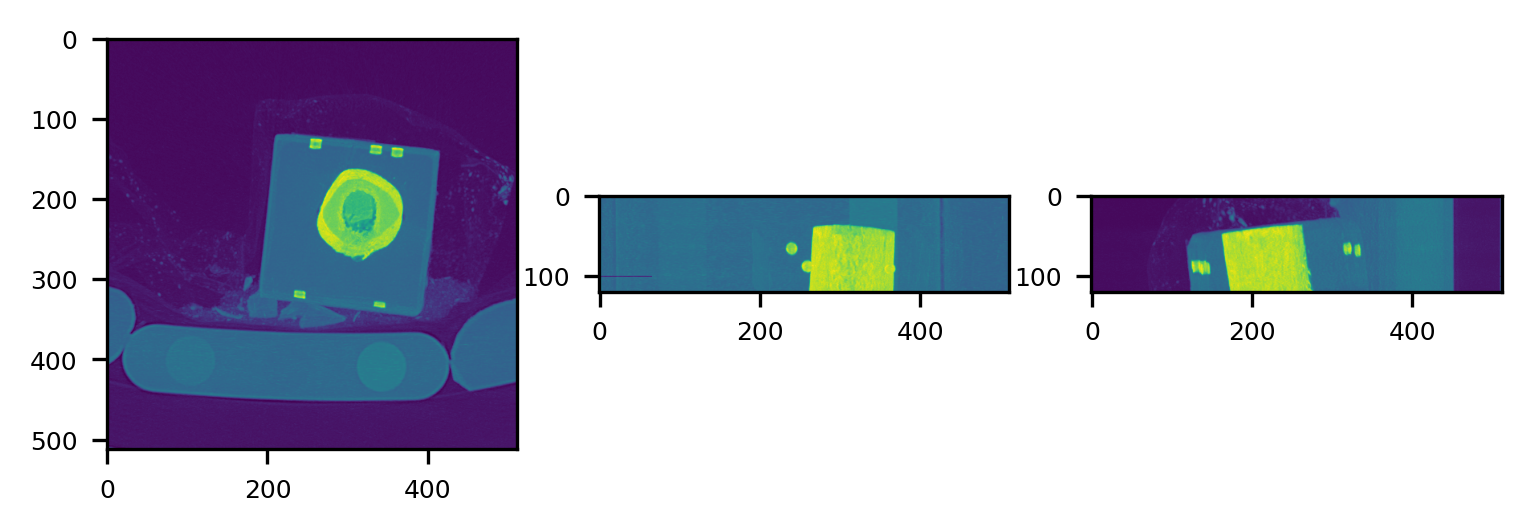

In [45]:
ru.plot_projections(data_3D_QCT[0:120,:,:])

M5_coors_QCT ~= 335, 140, 90